This notebook demonstrates how to use the [hyswap](https://doi-usgs.github.io/hyswap/) python package to estimate runoff over 10 water years (2013-2023)for a set of hydrologic units using streamflow measured at gages that overlap with the hydrologic units of interest. 

This example notebook relies on use of the [dataretrieval](https://github.com/DOI-USGS/dataRetrieval) package for downloading streamflow information from USGS NWIS.

Hydrologic units will be referred to as "hucs" and the drainage area captured by a streamflow gage will be referred to as a "basin". 

In [1]:
import dataretrieval
import hyswap
import pandas as pd
import matplotlib.pyplot as plt
from pynhd import WaterData
import contextily as ctx
import warnings
warnings.filterwarnings('ignore') # ignore warnings from dataretrieval

### Read in huc-basin intersection table

The huc-basin intersection dataset is created using shapefiles for hucs and site drainage basins, and is the output of the [hyswap geospatial data assembly repository](https://code.usgs.gov/water/computational-tools/surface-water-work/hyswap-geospatial-data-assembly) . For each huc-basin intersection, it contains the proportion of the huc's area in the basin, and the proportion of the basin's area in the huc. 

In [2]:
#| tbl-cap: The top rows of the intersection table created by the hyswap geospatial data assembly repository
# This example initially reads in the entire huc_basin_intersection table.
intersection_table_full = pd.read_csv('data/huc_props_tbl_conus.csv', 
                             converters = {0:str,1:str,2:str}
                             )

# drop first col that is the index from the csv. 
intersection_table_full.drop(columns=intersection_table_full.columns[0],
                    axis=1,
                    inplace=True
)
# view
intersection_table_full.head()

da_site_no    huc_id  prop_basin_in_huc  prop_huc_in_basin
0   05014500  17010207           0.002442           0.000066
1   05015500  17010207           0.001229           0.000066
2   05017500  17010207           0.000764           0.000185
3   06078500  17010207           0.000310           0.000071
4   06079500  17010207           0.000145           0.000071

### Select watershed to calculate runoff
This example focuses on a bounding box of HUC08's in Montana and Idaho. We will first filter to one of the hucs to show how to estimate runoff for a single huc, but later on we will calculate runoff for all hucs in the dataset. We will also establish the start and end dates over which we'd like to estimate runoff.

In [3]:
huc_shapes = WaterData('huc08').bybox([-115.065380, 45.947037, -112.692334, 47.572536])

In [4]:
#| tbl-cap: The first few rows of the geopandas dataframe from `pynhd`
huc_shapes.head()

geometry          id  ogc_fid  \
0  MULTIPOLYGON (((-114.57852 46.20392, -114.5776...  huc08.1292     1292   
1  MULTIPOLYGON (((-114.69247 46.37843, -114.6918...  huc08.1293     1293   
2  MULTIPOLYGON (((-114.68911 46.73654, -114.6880...  huc08.1294     1294   
3  MULTIPOLYGON (((-115.07836 47.01436, -115.0778...  huc08.1298     1298   
4  MULTIPOLYGON (((-112.53639 46.77149, -112.5364...  huc08.1314     1314   

                                    tnmid metasource sourcedata sourceorig  \
0  {7F625E44-2D3C-4BFE-B3AF-AE226738BE2E}       None       None       None   
1  {2D6097D0-9B6D-4E78-87D7-3C24C9C4544A}       None       None       None   
2  {A3199330-2CD2-4C45-9B94-C3AEFC801329}       None       None       None   
3  {715E4454-C297-4EE9-BB25-4EF556835571}       None       None       None   
4  {C41AF939-24F8-4457-A2CD-18B97877ED3C}       None       None       None   

  sourcefeat    loaddate gnis_id  areaacres    areasqkm states      huc8  \
0       None  2013-01-18    None     629847  2550.88035     ID  17060301   
1       None  2013-01-18    None     657072  2661.14160     ID  17060302   
2       None  2013-01-18    None     756177  3062.51685     ID  17060303   
3       None  2013-01-18    None     829790  3360.64950     ID  17060307   
4       None  2013-01-18    None    1199976  4859.90280     MT  17010201   

                          name  shape_leng  shape_area  
0                 Upper Selway    3.222792    0.295318  
1                 Lower Selway    4.501400    0.309359  
2                       Lochsa    4.726472    0.358058  
3  Upper North Fork Clearwater    3.458673    0.394984  
4             Upper Clark Fork    4.927125    0.567346

In [5]:
#| fig-cap: 'A map of the single HUC08, 17010209'
single_huc = huc_shapes['huc8'][9]

start_date = '2012-10-01'
end_date = '2023-09-30'

huc_shapes[huc_shapes['huc8'] == single_huc].explore()

If we wanted to calculate runoff for one huc, we would first identify which basins intersect the huc using the `identify_sites_from_geom_intersection` function. From this list of basins, we would then download their corresponding gage streamflow data. 

In [6]:
# Pull basin site ids from selected huc8 geom using the hyswap runoff identify sites from geom intersection function
basins_overlap_single_huc = hyswap.runoff.identify_sites_from_geom_intersection(geom_id = single_huc,
                                   geom_intersection_df = intersection_table_full,
                                   geom_id_col='huc_id',
                                   site_col='da_site_no',
                                   prop_geom_in_basin_col='prop_huc_in_basin',
                                   prop_basin_in_geom_col='prop_basin_in_huc'
                                   )

# output should be long list of sites ids. These are all the site_ids within the selected huc8 polygon
num_sites = len(basins_overlap_single_huc)
print(f'There are {num_sites} gaged basins that overlap this huc.')

There are 67 gaged basins that overlap this huc.


### Custom function for grabbing gage flow data from `dataretrieval` and converting it to runoff    
To estimate runoff for a huc, we need to create a dictionary of runoff data, where each key corresponds to a site id for a basin, and the item is a dataframe with a datetime index and runoff values for that site in a 'runoff' column. The function below leverages `dataretrieval` to pull streamflow data for a set of input sites over a specified date range, and then uses `hyswap`'s `streamflow_to_runoff` function in the `runoff` module to calculate area-based runoff using site drainage areas. It produces runoff values in millimeters per day. Note that this function can take some time, depending upon the size/number of queries. Additionally, it is not unusual for many sites to return no data.

In [7]:
def query_nwis_runoff_data(sites,
    start_date,
    end_date):
    print("Pulling site streamflow data and converting it to runoff. This may take some time...")
    # first, pull site info 
    info_df, _ = dataretrieval.nwis.get_info(sites=sites)
    # convert drainage area from sq mi to sq km
    info_df['da'] = info_df['drain_area_va'] * 2.58998811
    # info_df = info_df[['da', 'site_no']]
    # get streamflow data between start and end date
    dv_df, _ = dataretrieval.nwis.get_dv(
        sites=sites, parameterCd='00060',
        startDT=start_date, endDT=end_date,
        multi_index=False
        )
    # make dataframe list using the non-zero site list
    siteids = dv_df['site_no'].unique().tolist()
    df_dict_nwis_ro_data = {}

    # Loop through sites retrieved from nwis and calculate
    # runoff using hyswap function
    for site in siteids:
        ro_df = dv_df[dv_df['site_no']==site]
        da = info_df.loc[info_df['site_no']==site]['da']
        ro_df = hyswap.runoff.streamflow_to_runoff(ro_df, '00060_Mean', da, frequency='daily')
        df_dict_nwis_ro_data = {**df_dict_nwis_ro_data, **  {site: ro_df}}
    # print proportion of sites with data
    prop = len(siteids)/len(sites)
    print(f'\nProp of successful nwis queries from list of sites:\n {prop}')
    
    return(df_dict_nwis_ro_data)

### Download gage data
Let's try using `query_nwis_runoff_data` to download streamflow data and convert it to runoff (in mm/day) from 2013-2023 for our selected huc '07090001'. Note that not all gage sites listed in `basins_overlap_single_huc` will necessarily have data for the date range specified.

In [8]:
df_dict_nwis_ro_data = query_nwis_runoff_data(basins_overlap_single_huc,
start_date = start_date,
end_date = end_date)
display(df_dict_nwis_ro_data['06078500'])

Pulling site streamflow data and converting it to runoff. This may take some time...

Prop of successful nwis queries from list of sites:
 0.5074626865671642


site_no  00060_Mean 00060_Mean_cd    runoff
datetime                                                               
2014-05-01 00:00:00+00:00  06078500       923.0             A  3.366377
2014-05-02 00:00:00+00:00  06078500      1350.0             A  4.923737
2014-05-03 00:00:00+00:00  06078500      1520.0             A  5.543763
2014-05-04 00:00:00+00:00  06078500      1110.0             A  4.048406
2014-05-05 00:00:00+00:00  06078500      1100.0             A  4.011934
...                             ...         ...           ...       ...
2023-09-26 00:00:00+00:00  06078500        82.0             A  0.299071
2023-09-27 00:00:00+00:00  06078500        80.9             A  0.295060
2023-09-28 00:00:00+00:00  06078500        81.2             A  0.296154
2023-09-29 00:00:00+00:00  06078500        80.9             A  0.295060
2023-09-30 00:00:00+00:00  06078500        81.1             A  0.295789

[3440 rows x 4 columns]

### Calculate runoff for the huc
With daily basin runoff data in hand, we are ready to estimate runoff for the huc in mm/day. Please reference `hyswap`'s Calculations page to understand how runoff is calculated using this function. Briefly, this function finds basins contained within the huc and basins that contain the huc and calculates a weighted mean runoff value for each day. If `clip_downstream_basins` is set to True, the function only uses the smallest basin that contains the huc and disregards downstream gages that represent larger basins that contain the huc.

In [9]:
single_huc_runoff = hyswap.runoff.calculate_geometric_runoff(
    geom_id=single_huc,
    runoff_dict=df_dict_nwis_ro_data,
    geom_intersection_df=intersection_table_full,
    site_col='da_site_no',
    geom_id_col='huc_id',
    prop_geom_in_basin_col='prop_huc_in_basin',
    prop_basin_in_geom_col='prop_basin_in_huc',
    percentage=False,
    clip_downstream_basins=True,
    full_overlap_threshold=0.98
    )

Let's take a quick look at the calculated runoff.

<Axes: title={'center': 'Estimated Runoff for HUC 17010209'}, xlabel='Date', ylabel='Runoff (mm)'>

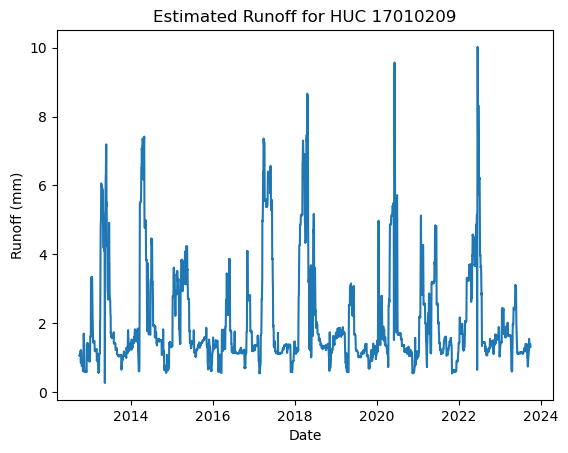

In [10]:
#| fig-cap: A runoff hydrograph for huc 17010209 using the `hyswap.plot_hydrograph` function
hyswap.plot_hydrograph(
    single_huc_runoff.to_frame(),
    data_col='geom_runoff',
    title=f'Estimated Runoff for HUC {single_huc}',
    yscale='linear',
    ylab='Runoff (mm)')

### Calculate runoff for all hucs
Now, we will calculate runoff for all of the hucs in the region selected. First, we'll identify the sites with drainage basins that intersect the seven hucs. Next, we'll need to use our custom function to download flow data and calculate runoff for each basin. Finally, we can leverage `hyswap`'s `calculate_multiple_geometric_runoff`, which loops through a list of hucs, finds their intersecting gage basins, and estimates runoff for each day in the dataset. Note that by setting the `clip_downstream_basins` argument to True, the function is only considering basins within each HUC08 and the smallest basin containing each HUC08 in the runoff estimate.

In [11]:
list_site_ids = []

# loop through to get all sites (identify_sites_from_geom_intersection() cannot accept multiple geom_ids) 
for huc in huc_shapes['huc8']:
    sites = hyswap.runoff.identify_sites_from_geom_intersection(
        geom_id = huc,
        geom_intersection_df = intersection_table_full,
        geom_id_col='huc_id',
        site_col='da_site_no',
        prop_geom_in_basin_col='prop_huc_in_basin',
        prop_basin_in_geom_col='prop_basin_in_huc'
        )
    
    list_site_ids.append(sites)

# join list of lists, as for loop above separates out the list of dfs 
all_site_ids = sum(list_site_ids,[])

In [12]:
# grab basin data using the all_site_ids list
df_nwis_ro_dict = query_nwis_runoff_data(all_site_ids, start_date=start_date,
end_date=end_date)

Pulling site streamflow data and converting it to runoff. This may take some time...

Prop of successful nwis queries from list of sites:
 0.11263736263736264


In [13]:
multiple_huc_runoff = hyswap.runoff.calculate_multiple_geometric_runoff(
    geom_id_list = huc_shapes['huc8'],
    runoff_dict = df_nwis_ro_dict,
    geom_intersection_df=intersection_table_full,
    site_col='da_site_no',
    geom_id_col='huc_id',
    prop_geom_in_basin_col= 'prop_huc_in_basin',
    prop_basin_in_geom_col='prop_basin_in_huc',
    percentage=False,
    clip_downstream_basins=True,
    full_overlap_threshold=0.98
    )

No runoff data associated with any basins contained within the geometry object 17060301 for the time period selected.
No runoff data associated with any basins contained within the geometry object 17060302 for the time period selected.


Like our single huc runoff calculation, we can take a look at the estimated runoff across all hucs.

(15614.0, 19630.0)

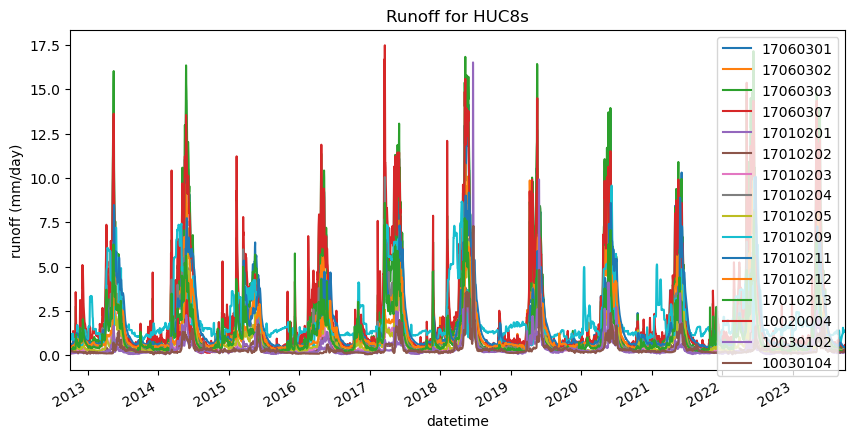

In [14]:
#| fig-cap: A multiple runoff hydrograph for all hucs pulled from `pynhd` in this example
# Plot 
fig, ax = plt.subplots(figsize=(10, 5))
multiple_huc_runoff.plot(ax = ax)

# Plot specs
plt.title('Runoff for HUC8s')
plt.ylabel('runoff (mm/day)')
plt.xlim(multiple_huc_runoff.index.min(),
          multiple_huc_runoff.index.max())

### Mapping the results of the runoff calculation
In this step of the analysis, we will calculate variable percentiles by day for each huc, and then use those percentiles to calculate a percentile for a new estimated runoff value. We will then plot these percentiles in a map of the hucs.  

In [15]:
huc_ids = multiple_huc_runoff.columns

percentile_results = {}

for huc_id in huc_ids:
    percentiles = hyswap.calculate_variable_percentile_thresholds_by_day(multiple_huc_runoff,
                                                                         data_column_name=huc_id)
    percentile_results[huc_id] = percentiles

Now, we will pull a new set of gage streamflow data for the first day of the next water year, and calculate runoff.

In [16]:
start_date = '2023-10-01'
end_date = '2023-10-01'
# grab basin data using the all_site_ids list
df_nwis_ro_dict_new = query_nwis_runoff_data(all_site_ids, start_date=start_date, end_date=end_date)

multiple_huc_runoff_new = hyswap.runoff.calculate_multiple_geometric_runoff(
    geom_id_list = huc_shapes['huc8'],
    runoff_dict = df_nwis_ro_dict_new,
    geom_intersection_df=intersection_table_full,
    site_col='da_site_no',
    geom_id_col='huc_id',
    prop_geom_in_basin_col= 'prop_huc_in_basin',
    prop_basin_in_geom_col='prop_basin_in_huc',
    percentage=False,
    clip_downstream_basins=True,
    full_overlap_threshold=0.98
    )

Pulling site streamflow data and converting it to runoff. This may take some time...

Prop of successful nwis queries from list of sites:
 0.10622710622710622
No runoff data associated with any basins contained within the geometry object 17060301 for the time period selected.
No runoff data associated with any basins contained within the geometry object 17060302 for the time period selected.


With runoff in hand, we can then calculate the percentile for this date for each HUC08, based on the percentiles we calculated for the previous 5-year period.

In [17]:
# Take the first day of the new water year and melt the dataframe so that each estimated runoff value for each huc
# is a row in the dataframe
huc_runoff_recent = multiple_huc_runoff_new.copy()
huc_runoff_recent['datetime'] = pd.to_datetime(huc_runoff_recent.index)
huc_runoff_recent_melt = pd.melt(huc_runoff_recent, id_vars=['datetime'], var_name='geom_id', value_name='runoff')
huc_runoff_recent_melt.set_index('datetime', inplace=True)

# Calculate estimated streamflow percentile for the new data by interpolating against
# the previously calculated percentile threshold levels
huc_perc_df = pd.DataFrame()

for huc, huc_df in huc_runoff_recent_melt.groupby('geom_id', group_keys=False):
    huc_perc_df = pd.concat([huc_perc_df, hyswap.percentiles.calculate_multiple_variable_percentiles_from_values(
            huc_df,'runoff', percentile_results[huc])])
# categorize streamflow by the estimated streamflow percentiles
huc_perc_df = hyswap.utils.categorize_flows(huc_perc_df, 'est_pct', schema_name="NWD")
huc_perc_df = huc_perc_df.reset_index(level='datetime')

And finally, create an interactive map showing HUC08 percentiles for October 1, 2023.

In [18]:
#| fig-cap: 'HUC08 colors correspond to the runoff percentiles for 10-01-2023 flow based on 5 years of estimated runoff data at the HUC08 scale, derived from gage basin flow data.'
# merge percentile information to geodataframe with polygon geometry
huc_shapes_percs = huc_shapes.merge(huc_perc_df.set_index('geom_id'), left_on='huc8', right_index=True)
# set up gdf format for plotting - ex. get rid of datetimes/timestamps
huc_shapes_percs['Date'] = huc_shapes_percs['datetime'].dt.strftime('%Y-%m-%d %H:%M')
schema = hyswap.utils.retrieve_schema('NWD')
flow_cond_cmap = schema['colors']
if 'low_color' in schema:
                flow_cond_cmap = [schema['low_color']] + flow_cond_cmap
if 'high_color' in schema:
                flow_cond_cmap = flow_cond_cmap + [schema['high_color']]
# set NA values to "Not Ranked" category
huc_shapes_percs['flow_cat'] = huc_shapes_percs['flow_cat'].cat.add_categories('Not Ranked')
huc_shapes_percs.loc[huc_shapes_percs['est_pct'].isna(), 'flow_cat'] = 'Not Ranked'
flow_cond_cmap = flow_cond_cmap + ['#d3d3d3'] # light grey
# renaming columns with user friendly names for map
huc_shapes_percs = huc_shapes_percs.drop(['loaddate', 'datetime'], axis=1)
huc_shapes_percs = huc_shapes_percs.rename(columns={'runoff':'Runoff (mm/day)',
                                                'est_pct':'Estimated Percentile',
                                                'huc8':'HUC08 ID',
                                                'name':'HUC08 Name',
                                                'flow_cat':'Streamflow Category'})
# Create map
huc_shapes_percs.explore(
    column="Streamflow Category",
    cmap=flow_cond_cmap,
    tooltip=["HUC08 ID", 'HUC08 Name',"Streamflow Category", "Runoff (mm/day)", "Estimated Percentile", "Date"],
    tiles="CartoDB Positron",
    marker_kwds=dict(radius=5),
    legend_kwds=dict(caption='Daily Mean Runoff Category'))